**확인된 내용**
1. [발렌타인 데이]쿠폰의 경우, 일뽀르노에서의 쿠폰 사용이 저조하다.
  + 이전결과 비교
  + 특정시점에 사용이 많은지를 확인
2. [발렌타인 데이]쿠폰의 경우, 일뽀르노에서의 쿠폰 사용이 저조하다.
3. 매장별 쿠폰사용겟수
4. 매장별 회원가입자수(누적)
5. 매장별 회원가입자수(일별)




In [ ]:
###############
# 1. import
#####

import pandas as pd
from datetime import datetime, timedelta
import re
import time 

# local only
import os
import cx_Oracle as oci
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)

# import send_email as se
from jinja2 import Template


In [ ]:
###############
# 1.데이터 불러오기
#####
# DB접속 : 접속정보 읽기
con_text = open("C:/Users/MAEIL/conn_info_MMBSHIP.txt", 'r', encoding='utf8')
con_text = con_text.read()

# DB 접속 : 실제 접속
conn = oci.connect(con_text[1:], encoding='UTF-8', nencoding='UTF-8')

In [ ]:

###############
# 2.데이터 정렬
#####
query = '''select (case when B.coopco_Cd = '7060' then 'ILP' else 'CJK' end) as 브랜드
        , (select stor_nm from mmbship.tc_afltstor where b.stor_no = stor_no) as 매장명
        , (select cpn_nm from mmbship.tpm_cpn where A.cpn_cd = cpn_cd) as 쿠폰명
        , apv_dt as 사용일자
        , dc_amt as 할인금액
        , (select tot_sel_amt from tp_trsc_ptcl where B.apv_no = apv_no) as 총결제금액
        , 1 as 사용겟수
        from mmbship.TPM_CPN_use B, mmbship.TPM_CPN_ISSU A 
        where A.CPN_ISSU_CD = B.CPN_ISSU_CD
        and B.can_apv_dt is null
        and a.cpn_st_cd ='2'
        and coopco_Cd in (7060)
        and to_date(apv_dt, 'YYYYMMDD') between TRUNC(sysdate,'MM') and LAST_DAY(sysdate)
        '''

df = pd.read_sql(query, con = conn )


In [ ]:
###############
# 2.데이터 정렬
#####
query = '''select (case when B.use_coopco_cd = '7060' then 'ILP' else 'CJK' end) as 브랜드
            , B.cpn_nm  as 쿠폰명
            , 1 as 쿠폰발급겟수
            from mmbship.TPM_CPN_ISSU A,  mmbship.tpm_cpn B
            where A.unfy_mmb_no is not null
            and A.cpn_cd = B.cpn_cd
            and B.use_coopco_cd = '7060'
            and to_date(issu_dt, 'YYYYMMDD') between TRUNC(sysdate,'MM') and LAST_DAY(sysdate)
        '''
dft = pd.read_sql(query, con = conn )


In [ ]:
df0 = pd.pivot_table(dft, values=['쿠폰발급겟수'], index=['브랜드', '쿠폰명'],  aggfunc=np.sum)
df0 = df0.reset_index()

In [ ]:
# 기준 테이블 작성
df_brand = pd.DataFrame()
df_brand['브랜드'] = 'ILP'
df_brand = df_brand.set_index(['브랜드'])

# 1.쿠폰별 사용겟수/금액
df1 = pd.pivot_table(df, values=['사용겟수', '할인금액', '총결제금액'], index=['브랜드', '쿠폰명'],  aggfunc=np.sum)
df1 = df1.reset_index()

In [ ]:
df1 = pd.merge(df0, df1, on = ['쿠폰명','브랜드'], how = 'left' )

In [ ]:
df1

,브랜드,쿠폰명,쿠폰발급겟수,사용겟수,총결제금액,할인금액
0,ILP,[Maeil Do!] 2023 발렌타인데이 이벤트 쿠폰,353,44.0,3655800.0,880000.0
1,ILP,[더키친 일뽀르노] 신규가입자 쿠폰(마르게리타 무료),349,151.0,15189000.0,3322000.0
2,ILP,[더키친 일뽀르노] 재방문 쿠폰(신메뉴 20%할인),323,3.0,460600.0,21320.0
3,ILP,[더키친 일뽀르노] 첫방문 쿠폰(1만원 할인),472,NaN,NaN,NaN


In [ ]:
# 2.일별 쿠폰사용 겟수
df2 = pd.pivot_table(df, values='사용겟수', columns=['사용일자'], index=['브랜드'],  aggfunc=np.sum)
df2 = pd.merge(df_brand, df2, left_index=True, right_on=['브랜드'], how='outer').fillna(0)

date2 = datetime.today().strftime('%Y%m%d')
image_name = date2[2:] +'_ILP_graph.png'

mpl.rc('figure', figsize=(10, 4))
fig = plt.figure( facecolor='#eeeeee')
plt.plot(df2.iloc[[0]].T[0:], marker="s", color = '#4a1968', markerfacecolor ='w', label='크리스탈 제이드', markersize  = 8)
lgd = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fancybox=True, shadow=True, ncol=1,fontsize='large')
plt.xticks(rotation=90)
plt.title('일별 쿠폰사용 추이',fontsize='x-large')

plt.savefig(image_name, bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=70)


NameError: name 'df_brand' is not defined

In [ ]:
# 3.매장별 쿠폰사용 겟수
df3 = pd.pivot_table(df, values=['사용겟수'], index=['브랜드', '매장명'],  aggfunc=np.sum)
pd.options.display.float_format = '{:0,.0f}'.format

In [ ]:
# 4.매장별 회원가입자수(합계)
query = '''
        select trunc(reg_dtm) as reg_dtm
        , (case when ntry_path = '7061' then '청담점' 
                when ntry_path = '7062' then '광화문점' 
                when ntry_path = '7063' then '신세계 강남점' 
                when ntry_path = '7064' then '신세계 대구점' 
                when ntry_path = '7065' then '신세계 센텀점' 
                when ntry_path = '7066' then '용인 에버랜드점' 
                when ntry_path = '7067' then '역삼 센터필드점'
            else '' end) as 매장명
        , count(*) as 회원가입
        from tm_mmb_info
        where ntry_path in ('7061', '7062', '7063', '7064', '7065', '7066', '7067')
        group by trunc(reg_dtm), ntry_path
        '''
df_member = pd.read_sql(query, con = conn )
df4 = pd.DataFrame(df_member.groupby('매장명')['회원가입'].sum()).reset_index()


In [ ]:
df4

,매장명,회원가입
0,광화문점,7
1,신세계 강남점,5
2,신세계 센텀점,5
3,역삼 센터필드점,1
4,용인 에버랜드점,2
5,청담점,13


In [ ]:
# 4.매장별 회원가입자수(합계)
query = '''
        /*쿠폰 유형별 발급 현황*/
        select M.cpn_NM, trunc(C.upd_dtm) as 발급일자, 1 as CNT
        from tpm_cpn_issu C, tpm_cpn M
        where C.cpn_cd = M.cpn_cd
        and C.unfy_mmb_no is not null
        and M.use_coopco_cd = 7060
        and to_char(C.upd_dtm , 'YYYYMM') = to_char(sysdate, 'YYYYMM')
        '''
df_coupon = pd.read_sql(query, con = conn )


In [ ]:
df_coupon.tail(2)

,CPN_NM,발급일자,CNT
408,[더키친 일뽀르노] 재방문 쿠폰(신메뉴 20%할인),2023-02-09,1
409,[더키친 일뽀르노] 재방문 쿠폰(신메뉴 20%할인),2023-02-09,1


In [ ]:
df5 = pd.pivot_table(df_coupon, values = 'CNT', columns=['CPN_NM'], index=['발급일자'],  aggfunc='count')


In [ ]:
df5.columns

Index(['[더키친 일뽀르노] 신규가입자 쿠폰(마르게리타 무료)', '[더키친 일뽀르노] 재방문 쿠폰(신메뉴 20%할인)',
       '[더키친 일뽀르노] 첫방문 쿠폰(1만원 할인)'],
      dtype='object', name='CPN_NM')

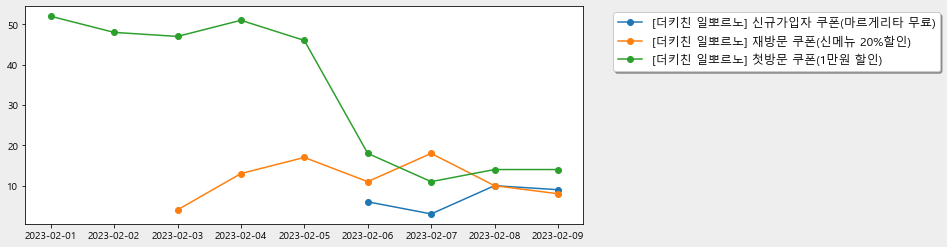

In [ ]:
fig = plt.figure( facecolor='#eeeeee')
plt.plot(df5,'o-',  label=df5.columns )
plt.legend(list(df5.columns), loc='upper right', bbox_to_anchor=(1.65, 1), fancybox=True, shadow=True, ncol=1,fontsize='large')
plt.xticks(rotation=90)
plt.title('일별 쿠폰사용 추이',fontsize='x-large')
plt.show()

In [ ]:
###############
# 3.이메일 발송
#####

# 이미지 파일 조작
import io
import base64
from PIL import Image

# 이미지 파일을 엽니다.
img = Image.open("./"+ image_name)

# 스트림에 이미지 데이터를 저장합니다.
bytearr = io.BytesIO()
img.save(bytearr, format="png")

# 이미지 바이너리를 읽고 base64로 인코딩합니다.
imgbytearr = bytearr.getvalue()
encoded_image = base64.b64encode(imgbytearr).decode("utf-8")

# 이미지 파일 삭제
os.remove("./"+ image_name)


In [ ]:
# 이메일 양식(내용) frame 구성하기
message_tmpl="""
<html>
    <!DOCTYPE html>
    <html>
    <head lang ="ko">
      <meta charset ="UTF-8">
      <title>{{title1}}</title>
    </head>
    <style type="text/css">
        table, th, td {
            font-size: 8pt;
            border-collapse: collapse;
            font-family: Malgun Gothic;
            white-space: nowrap;
            border: 1px solid #bcbcbc;
            }
        thead tr {
            background-color: #0d47a1;
            color: #ffffff;
            }
    </STYLE>
    <BODY style="FONT-SIZE: 10pt; font-family: Malgun Gothic">
    안녕하세요,<br>
    <br>
    {{send_date}}일 기준, 일뽀르노 브랜드별 쿠폰사용 내용 공유드립니다.<br>
    <br>
    <b>1. 당월 쿠폰운영 List </b><br>
    {{ df1_html }}<br>
    <b>2. 일별 쿠폰사용 추이</b><br>
    <img src="data:image/png;base64,{{encoded_image}}"/><br>
    <br>
    <b>3. 매장별 쿠폰 사용 현황</b><br>
    {{ df3_html }}<br>
    <br>
    <SPAN style="COLOR: #808080">{{add_text1}}</SPAN><br>
    <SPAN style="COLOR: #808080">{{add_text2}}</SPAN><br>
    <br>
    감사합니다.<br>
    <br>
    </BODY>
</html>"""

# 이메일 양식(내용) 변동 내용 정의
render_data = {
    'send_date' : (datetime.today()).strftime('%Y-%m-%d'),
    'df1_html' : df1.to_html(),
    'df3_html' : df3.to_html(),
    'encoded_image' : encoded_image,
    'add_text1' : "*  본 메일은 발신전용입니다.",
    'add_text2' : "** (내용/기술문의 : 고객정보전략담당, 박경하 )"
}

t= Template(message_tmpl)
html_report = t.render(render_data)


In [ ]:


# 발송 변수 설정

to_users = 'junlee@maeil.com; jmseo@maeil.com; sijung@maeil.com;'
to_cc = 'khpark@maeil.com; mj@maeil.com; yhkee@maeil.com'


# 메일제목
now = datetime.today()    # 현재
date = now.strftime('%Y%m%d')

subject = "[자동발송] 일뽀르노 쿠폰사용 현황_v2"

# 본문
html = html_report

# 첨부파일 추가
attach = None


#메일 발송
import win32com.client

outlook = win32com.client.Dispatch("Outlook.Application")
send_mail = outlook.CreateItem(0)

send_mail.To = to_users #메일 수신인
send_mail.CC = to_cc #메일 수신인

send_mail.Subject = subject #메일 제목
send_mail.HTMLBody =html_report
# if attach:
#     for file in attach:
#         new_Mail.Attachments.Add(attach)
 
# send_mail.Send()
send_mail.Display(True)



In [ ]:
###############
# 4.매장별 회원가입자수(합계)
#####
query = '''
        select trunc(reg_dtm) as 일자
        , unfy_mmb_no
        , (case when ntry_path = '7061' then '청담점' 
                when ntry_path = '7062' then '광화문점' 
                when ntry_path = '7063' then '신세계 강남점' 
                when ntry_path = '7064' then '신세계 대구점' 
                when ntry_path = '7065' then '신세계 센텀점' 
                when ntry_path = '7066' then '용인 에버랜드점' 
                when ntry_path = '7067' then '역삼 센터필드점'
            else '' end) as 매장명
        , count(*) as 회원가입자수
        from tm_mmb_info
        where ntry_path in ('7061', '7062', '7063', '7064', '7065', '7066', '7067')
        and unfy_mmb_no not in ('6768277', '6768289', '6768311', '6768345', '4264108', '6756977')
        group by trunc(reg_dtm), unfy_mmb_no, ntry_path
        '''
df_member = pd.read_sql(query, con = conn )

## 1.일별 쿠폰사용+회원가입 현황

In [ ]:
date_start = pd.to_datetime(datetime.today()) - pd.offsets.MonthEnd(1)
date_end = pd.to_datetime(datetime.today(), format='%Y.%m') + pd.offsets.MonthEnd(0)
date2 = datetime.today().strftime('%Y%m%d')

datelist = pd.date_range(start=date_start,end=date_end, freq='D', normalize = True).tolist()

In [ ]:
report01 = pd.DataFrame()
report01['일자']= datelist[1:]

In [ ]:
df1_temp = pd.pivot_table(df_coupon, values='쿠폰사용겟수', index=['일자'],  aggfunc=np.sum).reset_index()
df2_temp = pd.pivot_table(df_member, values='회원가입자수', index=['일자'],  aggfunc=np.sum).reset_index()

In [ ]:
report01 = pd.merge(report01, df1_temp, on = '일자', how = 'left')
report01 = pd.merge(report01, df2_temp, on = '일자', how = 'left')

C:\Users\MAEIL\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\MAEIL\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\MAEIL\AppData\Roaming\Python\Python37\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\MAEIL\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Suppor

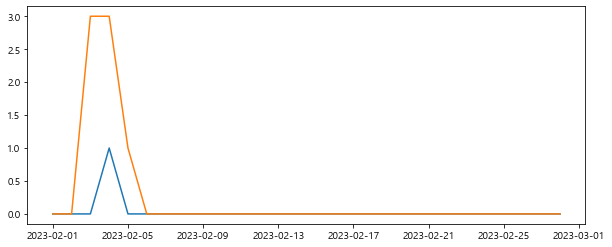

In [ ]:
plt.plot(report01['일자'], report01['쿠폰사용겟수'].fillna(0),  )
plt.plot(report01['일자'], report01['회원가입자수'].fillna(0),  )
plt.show()

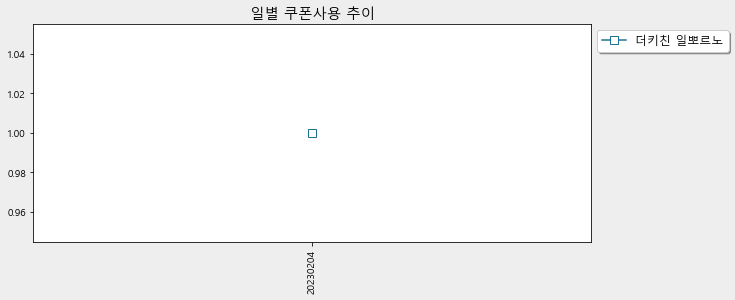

In [ ]:
date2 = datetime.today().strftime('%Y%m%d')
image_name = date2[2:] +'_ILP_graph.png'

mpl.rc('figure', figsize=(10, 4))
fig = plt.figure( facecolor='#eeeeee')
plt.plot(df2.iloc[[0]].T[0:], marker="s", color = '#207191', markerfacecolor ='w', label='더키친 일뽀르노', markersize  = 8)
lgd = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fancybox=True, shadow=True, ncol=1,fontsize='large')
plt.xticks(rotation=90)
plt.title('일별 쿠폰사용 추이',fontsize='x-large')
# plt.savefig(image_name, bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=70)
plt.show()

In [ ]:
df2

,20230204
브랜드,
ILP,1


In [ ]:
###############
# 2. 쿠폰 발급/사용(누적)
#####
query = '''
        select I.cpn_cd, M.cpn_nm as "쿠폰명", '쿠폰발급' as gubun, count(*) AS CNT
        from  tpm_cpn_issu I, tpm_cpn M
        where I.cpn_cd in ( 'CP230125003', 'CP230125002', 'CP230125001' )
        and I.cpn_cd = M.cpn_Cd
        and I.unfy_mmb_no is not null
        and I.unfy_mmb_no not in ('6768277', '6768289', '6768311', '6768345', '4264108', '6756977')
        group by I.cpn_cd, M.cpn_nm
        union all
        select I.cpn_cd, M.cpn_nm as "쿠폰명", '쿠폰사용' AS gubun , count(*) CNT from  tpm_cpn_issu I, tpm_cpn M
        where I.cpn_cd in ( 'CP230125003', 'CP230125002', 'CP230125001' )
        and I.cpn_cd = M.cpn_Cd
        and I.cpn_st_Cd = '2' and I.can_apv_no is null
        group by I.cpn_cd, M.cpn_nm
        '''
df_coupon_all = pd.read_sql(query, con = conn )

report_02 = pd.pivot_table(df_coupon_all, values='CNT', columns =['GUBUN'], index=['쿠폰명'],  aggfunc=np.sum).reset_index()
report_02 = report_02[['쿠폰명','쿠폰발급','쿠폰사용']].fillna(0)

In [ ]:
report_02

GUBUN,쿠폰명,쿠폰발급,쿠폰사용
0,[더키친 일뽀르노] 신규가입자 쿠폰(마르게리타 무료),6,0
1,[더키친 일뽀르노] 재방문 쿠폰(신메뉴 20%할인),50,1
2,[더키친 일뽀르노] 첫방문 쿠폰(1만원 할인),274,0


## 3.회원 가입자 수

In [ ]:
df_member.tail(2)

,REG_DTM,UNFY_MMB_NO,매장명,회원가입
5,2023-02-04,6783264,광화문점,1
6,2023-02-05,6783775,용인 에버랜드점,1


In [ ]:
# 3.매장별 쿠폰사용 겟수
df_report02 = pd.pivot_table(df_member, values=['회원가입자수'], index=['REG_DTM'],  aggfunc=np.sum).reset_index()

In [ ]:
df_report02

,REG_DTM,회원가입자수
0,2023-02-03,3
1,2023-02-04,3
2,2023-02-05,1


In [ ]:
###############
# 4.매장별 회원가입자수(합계)
#####
query = '''
        select trunc(reg_dtm) as reg_dtm
        , (case when ntry_path = '7061' then '청담점' 
                when ntry_path = '7062' then '광화문점' 
                when ntry_path = '7063' then '신세계 강남점' 
                when ntry_path = '7064' then '신세계 대구점' 
                when ntry_path = '7065' then '신세계 센텀점' 
                when ntry_path = '7066' then '용인 에버랜드점' 
                when ntry_path = '7067' then '역삼 센터필드점'
            else '' end) as 매장명
        , count(*) as 회원가입
        from tm_mmb_info
        where ntry_path in  ('7061', '7062', '7063', '7064', '7065', '7066', '7067')
        and unfy_mmb_no not in ('6768277', '6768289', '6768311', '6768345', '4264108', '6756977')
        group by trunc(reg_dtm), ntry_path
        '''
df_member = pd.read_sql(query, con = conn )

In [ ]:
df_member

,REG_DTM,매장명,회원가입
0,2023-02-03,청담점,1
1,2023-02-03,신세계 센텀점,1
2,2023-02-03,용인 에버랜드점,1
3,2023-02-04,청담점,2
4,2023-02-04,광화문점,1
5,2023-02-05,용인 에버랜드점,1


In [ ]:
df2 = pd.pivot_table(df, values='사용겟수', columns=['사용일자'], index=['브랜드'],  aggfunc=np.sum)


## 4.신규가입 및 쿠폰사용 현황

In [ ]:
###############
# 4.매장별 회원가입자수(합계)
#####
query = '''
        select trunc(reg_dtm) as reg_dtm
        , unfy_mmb_no
        , (case when ntry_path = '7061' then '청담점' 
                when ntry_path = '7062' then '광화문점' 
                when ntry_path = '7063' then '신세계 강남점' 
                when ntry_path = '7064' then '신세계 대구점' 
                when ntry_path = '7065' then '신세계 센텀점' 
                when ntry_path = '7066' then '용인 에버랜드점' 
                when ntry_path = '7067' then '역삼 센터필드점'
            else '' end) as 매장명
        , count(*) as 회원가입
        from tm_mmb_info
        where ntry_path in ('7061', '7062', '7063', '7064', '7065', '7066', '7067')
        and unfy_mmb_no not in ('6768277', '6768289', '6768311', '6768345', '4264108', '6756977')
        group by trunc(reg_dtm), unfy_mmb_no, ntry_path
        '''
df_member = pd.read_sql(query, con = conn )

In [ ]:
df_member

,REG_DTM,UNFY_MMB_NO,매장명,회원가입
0,2023-02-03,6782507,신세계 센텀점,1
1,2023-02-03,6782684,청담점,1
2,2023-02-03,6782751,용인 에버랜드점,1
3,2023-02-04,6783247,청담점,1
4,2023-02-04,6783252,청담점,1
5,2023-02-04,6783264,광화문점,1
6,2023-02-05,6783775,용인 에버랜드점,1


In [ ]:
ㅇㄹ = pd.DataFrame(df_member.groupby('매장명')['회원가입'].sum()).reset_index()

In [ ]:
df4

,매장명,회원가입
0,광화문점,1
1,신세계 센텀점,1
2,용인 에버랜드점,2
3,청담점,3


In [ ]:
df_temp = pd.merge(df3, df4, on='매장명', how='outer').fillna('')

In [ ]:
df_temp[['매장명', '회원가입', '사용겟수']]

,매장명,회원가입,사용겟수
0,광화문점,1,1
1,신세계 센텀점,1,
2,용인 에버랜드점,2,
3,청담점,3,


## 5.매장별 회원가입자수(일별)

In [ ]:
df

,브랜드,매장명,쿠폰명,사용일자,할인금액,총결제금액,사용겟수
0,ILP,광화문점,[더키친 일뽀르노] 재방문 쿠폰(신메뉴 20%할인),20230204,4600,23000,1


In [ ]:
report_05 =pd.pivot_table(df_member, values='CNT', index=['REG_DTM','CHANNEL'],  aggfunc='sum').fillna(0)

KeyError: 'CNT'

In [ ]:
# report_05.index[:]['CHANNEL']

In [ ]:
fig = plt.figure(figsize=(10, 4), facecolor='#eeeeee' )

# 그래프 
ax1 = plt.subplot2grid((1, 1), (0, 0))
# plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.5)
plt.plot(report_05,'.-',  label=report_05.columns )
ax1.legend(list(report_05.columns), loc='upper right', bbox_to_anchor=(1.4, 0.8), fancybox=True, shadow=True, fontsize='large')
plt.grid(True, axis='y')
plt.xticks(rotation=90)
plt.title('일별 리뷰 수(제품별 Trend)',fontsize='x-large')
plt.ylabel('리뷰 수(건)')
plt.show()

<Figure size 720x288 with 0 Axes>